<p style="text-align: center;font-size: 60px;">Stars</p>
<br\><br\>
PLAsTiCC Astronomical Classification<br/>
https://www.kaggle.com/c/PLAsTiCC-2018
<br\><br\>

[Kernel]<br\>
* Kernel Strategies for Flux Time Series Preprocessing<br/>
https://www.kaggle.com/mithrillion/strategies-for-flux-time-series-preprocessing

* Light Gradient Boosting Machine<br/>
https://www.kaggle.com/iprapas/ideas-from-kernels-and-discussion-lb-1-135
<br\>

* Kernel using Neural Network<br/>
https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import gc

In [3]:
import lightgbm as lgb

<p style="text-align: center;font-size: 40px;">Part 1. EDA on Metadata</p>
<br\>

# 1. Load Training Metatata

In [5]:
# tm: train_metadata
TM = pd.read_csv('training_set_metadata.csv')
print("Size:", TM.shape[0])
TM.sort_values(by=['object_id'], ascending=True).head(3)

Size: 7848


,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42


# 2. Modify column property and Remove unused column
* Change datatype into categorical data for column['DDF', 'target']
* Remove unused column['hostgal_specz']

In [6]:
TM['ddf'] = TM['ddf'].astype('category')
TM['target'] = TM['target'].astype('category')
TM.drop(['hostgal_specz'], axis=1, inplace=True)
TM.sort_values(by=['object_id'], ascending=True).head(3)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,42


# 3. Describe data
* Categorical data: (unique/top/freq)
* Numerical data: the rest

#### Column description
0. $ra$: right ascension, sky coordinate: co-longitude in degrees.
0. $decl$: declination, sky coordinate: co-latitude in degrees.
0. $gal\_l$: galactic longitude in degrees.
0. $gal\_b$: galactic latitude in degrees.
0. $ddf(category)$: A flag to identify the object as coming from the DDF survey area (with value DDF = 1 for the DDF, DDF = 0 for the WFD survey).
0. $hostgal\_photoz$: The photometric redshift of the host galaxy of the astronomical source. Target is in galactic if value equals 0, otherwise extra-galactic.
0. $hostgal\_photoz\_err$: The uncertainty on the hostgal_photoz based on LSST survey projections.
0. $distmod$: The distance to the source calculated from hostgal_photoz and using general relativity.

0. $mwebv$: MW E(B-V). this ‘extinction’ of light is a property of the Milky Way (MW) dust along the line of sight to the astronomical source, and is thus a function of the sky coordinates of the source ra, decl. This is used to determine a passband dependent dimming and redenning of light from astronomical sources, and based on the Schlafly dust models. Float32

0. $target(category)$: The class of the astronomical source.

In [5]:
TM.describe(include='all')
# First 3 rows for categorical data, the rest rows are for numerical data

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
count,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.0,7848.000000,7848.000000,5523.000000,7848.000000,7848.0
unique,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,14.0
top,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,90.0
freq,NaN,NaN,NaN,NaN,NaN,5732.0,NaN,NaN,NaN,NaN,2313.0
mean,4.810375e+07,169.719379,-27.254846,230.466784,-20.115526,NaN,0.357885,0.155695,41.263961,0.081953,NaN
std,4.347364e+07,114.212761,20.248556,97.416392,40.390899,NaN,0.545552,0.300367,2.262711,0.150598,NaN
min,6.150000e+02,0.175781,-64.760857,0.107681,-89.615573,NaN,0.000000,0.000000,31.996100,0.003000,NaN
25%,3.180865e+05,62.402344,-44.597992,207.248509,-54.509752,NaN,0.000000,0.000000,39.845250,0.018000,NaN
50%,4.131719e+07,150.996094,-27.279613,244.127187,-30.217582,NaN,0.210300,0.018000,41.167900,0.032000,NaN
75%,8.665901e+07,282.875976,-8.838267,313.224277,16.913859,NaN,0.431200,0.122375,42.398550,0.076000,NaN


# 4. Explore the data with plots

In [6]:
TM.head(3)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,42


In [38]:
TM_copy = TM.copy()
del TM_copy['object_id'], TM_copy['target']

## 4.0 Plot relationships between attributes using correlaton coefficient

pair plot

In [39]:
# TM_copy = TM.copy()
# del TM_copy['object_id'], TM_copy['target']
# sm = pd.plotting.scatter_matrix(TM_copy, figsize=(15, 15), alpha=0.3, diagonal = 'kde')

# #Change label rotation
# [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
# [s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

# #May need to offset label when rotating to prevent overlap of figure
# [s.get_yaxis().set_label_coords(-0.7,0.5) for s in sm.reshape(-1)]

# plt.show()

correlation coefficient

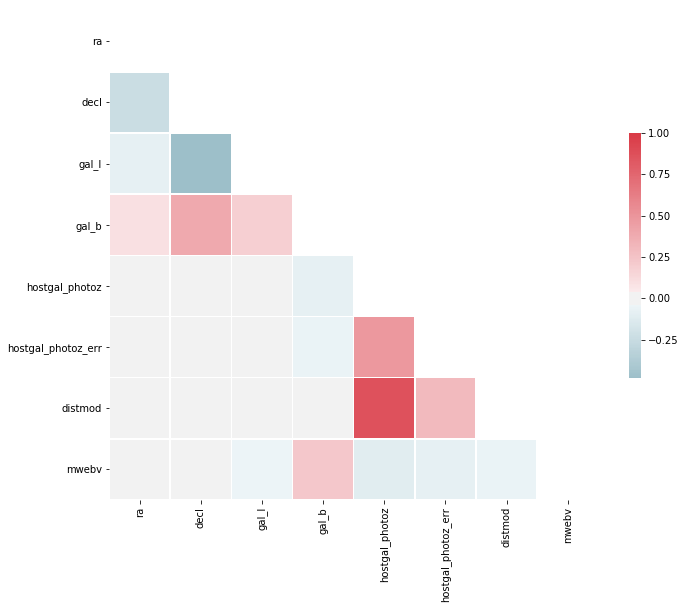

In [43]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = TM_copy.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<span style="color:blue">
Finding:<br/>
distmod and hostal_photoz are highly correlated.
</span>

## 4-1 How does the distribution of position look like in the sky?

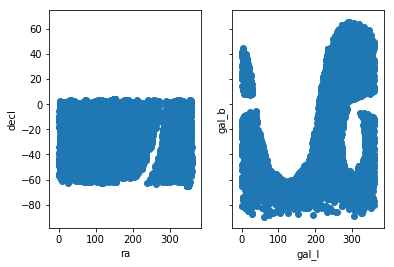

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True) # (row, col) = (1, 2)

ax1.set_xlabel('ra'), ax1.set_ylabel('decl')
ax1.scatter(TM.ra, TM.decl)

ax2.set_xlabel('gal_l'), ax2.set_ylabel('gal_b')
ax2.scatter(TM.gal_l, TM.gal_b)

## 4-2 How many targets are there, and how does the distribution of position look like for each target?

In [12]:
targets = sorted(list(TM.target.unique()))
print('size:', len(targets))
print('list:', targets)

size: 14
list: [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


1

## How many values in each class?

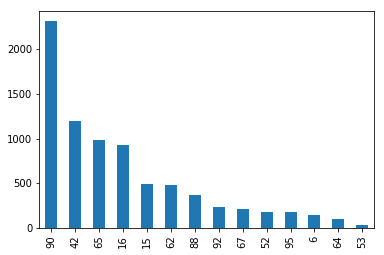

In [26]:
TM['target'].value_counts().plot.bar()


<span style="color:blue">
Finding:<br/>
There are 14 target classes, and the class names are listed above.
</span>

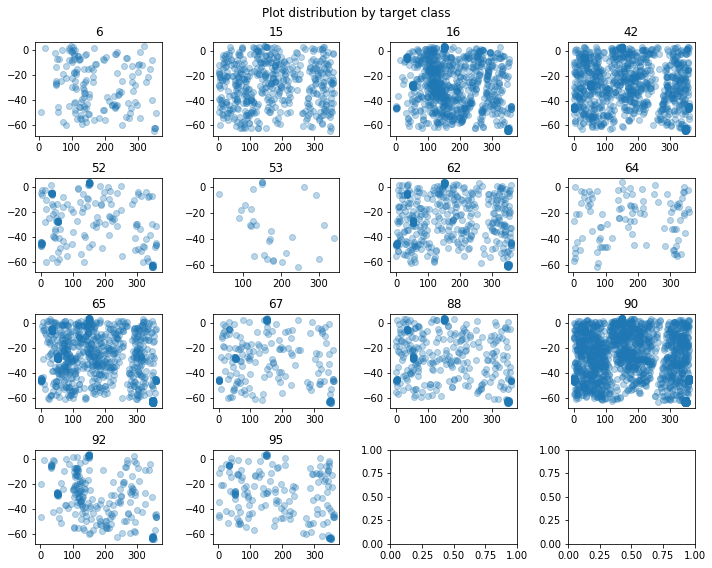

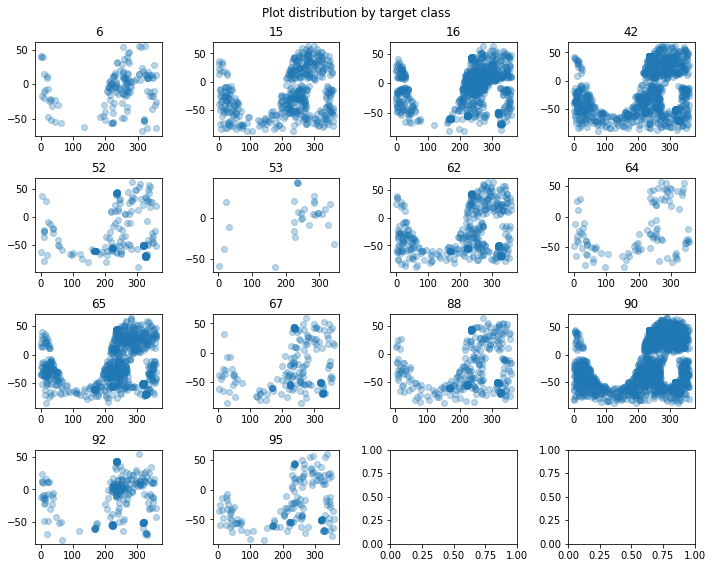

In [9]:
# plot the distribution
def plot_position(df, targets, using_sky_coordinate=True):
    '''plot the position distribution in the sky for each target seperately'''
    
    # 1. auto get the appropriate (row, col) value for the plot area
    block_size = 0
    while block_size * block_size < len(targets):
        block_size += 1
        
    # 2. creat subplots using size and set the canvas
    fig, axes = plt.subplots(block_size, block_size) #(row, col)
    fig.set_size_inches(10, 8, forward=True)
    fig.suptitle('Plot distribution by target class')
    
    # 3. Plot each target class seperately into different subplot area using axes[rol, col]
    row, col = 0, 0
    for target in targets:
        targetDF = df[df.target==target]
        if col < block_size:
            axes[row, col].set_title(str(target))
            
            if using_sky_coordinate:
                axes[row, col].scatter(x=targetDF.ra, y=targetDF.decl, alpha=0.3)
            else:
                axes[row, col].scatter(x=targetDF.gal_l, y=targetDF.gal_b, alpha=0.3)
            
            col += 1
            if col == block_size:
                row += 1
                col = 0
                
    # 4. Layout setting, fig.subplots_adjust helps to avoiding overlapping between main title and sub title
    plt.tight_layout()
    fig.subplots_adjust(top=0.92)
    
plot_position(TM, targets)
plot_position(TM, targets, False)

<span style="color:blue">
Finding:<br/>
Distribution of position shows that objects of each single target class are spread across the universe widely. Position may not be a helpful feature while doing classification.
</span>

## 4-3 According to data discription, objects can be described as: *Galactic / Extra-Galactic* based on the value of redshift (0 is in galaxy) Can you show that?

*photometric redshift is represented in hostgal_photoz column* <br>
Galactic vs extragalactic: The given redshift for objects in our own galaxy is given as zero

* Can you tell a target class is in galactic or extra-galactic?
* Is the (class)-(galactic type) relationship consistent across whole dataset?

In [71]:
TM_copy = TM.copy()
TM_copy['galactic'] = (pd.isnull(TM_copy.hostgal_photoz) | TM_copy.hostgal_photoz == 0)

groupedDF = TM_copy.groupby(['target', 'galactic']).size().to_frame('count').reset_index()
groupedDF

,target,galactic,count
0,6,True,151
1,15,False,495
2,16,True,924
3,42,False,1193
4,52,False,183
5,53,True,30
6,62,False,484
7,64,False,102
8,65,True,981
9,67,False,208


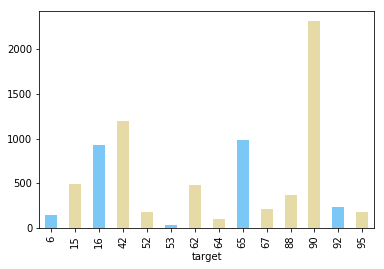

In [73]:
colors = [np.where(groupedDF['galactic'], 'xkcd:lightblue', 'xkcd:beige')]
groupedDF.plot.bar(x='target', y='count', color=colors, legend=False)

In [12]:
# seperate data into sub group for further analysis
df_Galactic = TM_copy[TM_copy.galactic]
df_ExtraGalactic = TM_copy[~TM_copy.galactic]
print('Galactic:', sorted(list(df_Galactic.target.unique())))
print('Extra-Galactic:', sorted(list(df_ExtraGalactic.target.unique())))

Galactic: [6, 16, 53, 65, 92]
Extra-Galactic: [15, 42, 52, 62, 64, 67, 88, 90, 95]


<span style="color:blue">
Finding:<br/>
In training set, whether a target calss is galactic is consistnet across entire dataset. For example, target calss 6 has 151 objects, and they are all identified as extra-galacticc. To sum up, 9 classes out of 14 classes is galactic, while the rest 5 class is extra-galactic.
</span>

## 4-4 Explore numerical attributes for each class with simple statistics. See if there exist any trend or pattern.

In [13]:
def plot_statistic(df, df_name, groupby_column, analysis_columns):
    for column in analysis_columns:
        df.boxplot(column=column, by=groupby_column, figsize=(8,6))
        plt.title(""), plt.suptitle("%s - %s" % (df_name, column))
        plt.show()

### 4-4-1 Statistical analysis on galactic group

In [14]:
df_Galactic.head(3)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,galactic
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0,0.0,NaN,0.017,92,True
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,NaN,0.020,65,True
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0,0.0,NaN,0.018,65,True


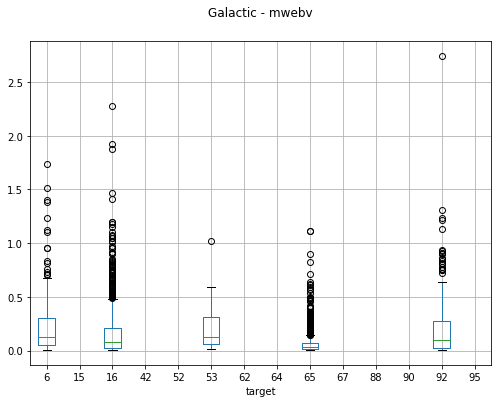

In [15]:
analysis_columns = ['mwebv']
plot_statistic(df=df_Galactic, df_name='Galactic', groupby_column='target', analysis_columns=analysis_columns)

### 4-4-2 Statistical analysis on extra - galactic group

In [16]:
df_ExtraGalactic.head(3)

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,galactic
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.6267,0.2552,45.4063,0.007,88,False
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2262,0.0157,40.2561,0.021,42,False
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.2813,1.1523,40.7951,0.007,90,False


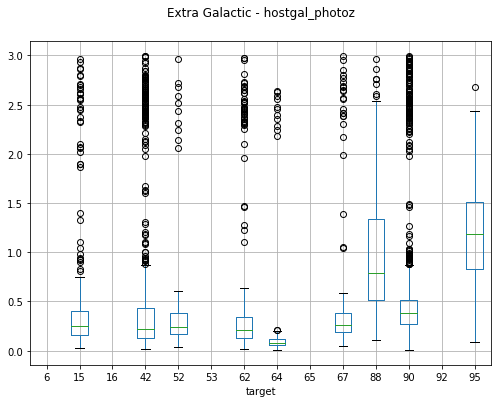

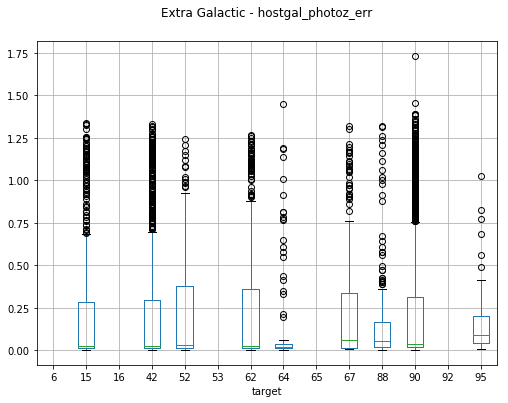

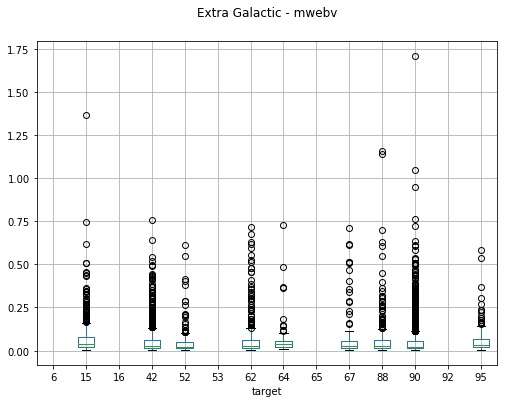

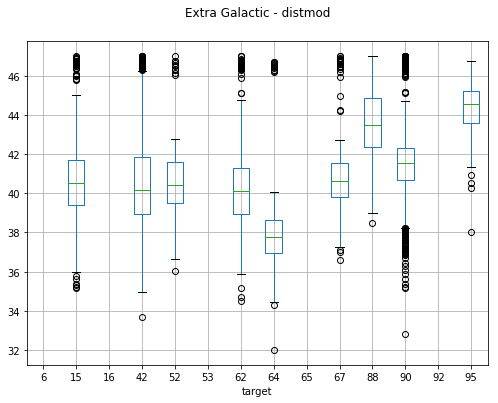

In [17]:
analysis_columns = ['hostgal_photoz', 'hostgal_photoz_err', 'mwebv', 'distmod']
plot_statistic(df=df_ExtraGalactic, df_name='Extra Galactic', groupby_column='target', analysis_columns=analysis_columns)

<span style="color:blue">
Finding:<br/>
According to the statistical figures above, the distribution of an attribute value among different target classes are overlapped, so there is no direct indicator for classification.<br\>
However, if a object is labeled as extra-galactic and it has distmod >= 42, it has higher chance to be in class 88 and 95. On the other hand, if a object has distmod <= 40, it has higher chance to be in class 64.
</span>

<p style="text-align: center;font-size: 40px;">Part 2. EDA on Time series data</p>
<br\>

# 1. Load Training Time Series Data

In [49]:
# ts: train_series_data
TS = pd.read_csv('./input/training_set.csv')
print("Size:", TS.shape[0])
TS.sort_values(by=['object_id'], ascending=True).head(10)

Size: 1421705


,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
239,615,60493.2639,4,-406.733521,3.772714,1
238,615,60493.2527,3,-530.644592,3.672556,1
237,615,60493.2450,1,-1031.102905,6.378702,1
236,615,60493.2372,2,-680.489441,4.065931,1
235,615,60490.3024,5,-395.406128,8.139952,1
234,615,60490.2913,4,-371.286377,3.985296,1
233,615,60490.2802,3,-405.614258,3.513195,1
232,615,60490.2725,1,-624.518799,4.704853,1
240,615,60493.2750,5,-358.876160,7.310321,1


# 2. Check distributions

## 2-1 Check the distribution of time series lengths

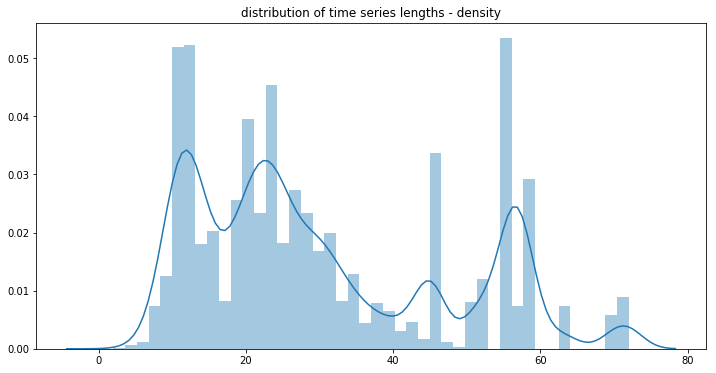

In [64]:
ts_lens = TS.groupby(['object_id', 'passband']).size()
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(ts_lens, ax=ax)
ax.set_title('distribution of time series lengths - density')
plt.show()

## 2-2 Check the distribution of number of observations at each time point

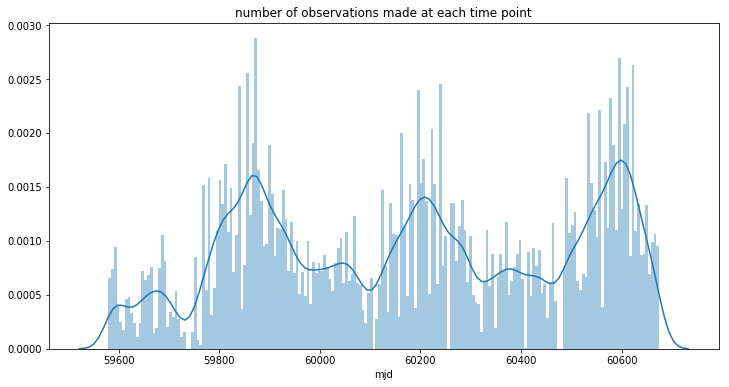

In [66]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(TS['mjd'], ax=ax, bins=200)
ax.set_title('number of observations made at each time point')
plt.show()

## 2-3 Check the distribution of number of observations of a single object at each time point

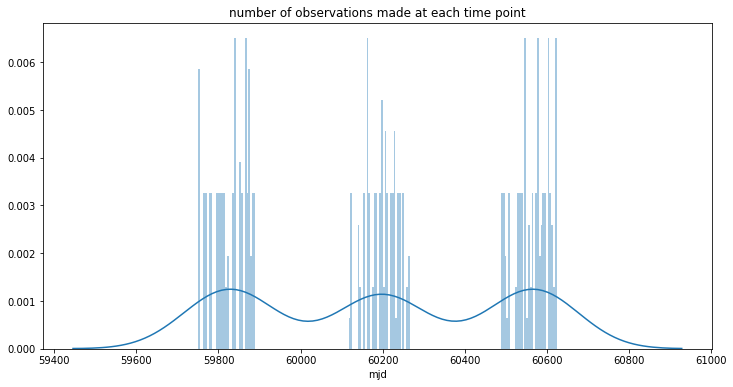

In [68]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(TS[TS.object_id==615]['mjd'], ax=ax, bins=200)
ax.set_title('number of observations made at each time point')
plt.show()

## 2-3 Check the distributoin of number of observations of a single passband of a single object at each time point

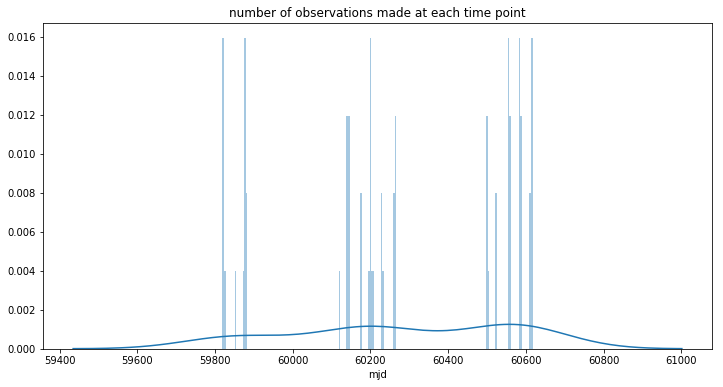

In [69]:
f, ax = plt.subplots(figsize=(12, 6))
sns.distplot(TS[(TS.object_id==615) & (TS.passband==0)]['mjd'], ax=ax, bins=200)
ax.set_title('number of observations made at each time point')
plt.show()

<span style="color:blue">
Finding:<br/>
1. The amount of obeservation across object/passband is not evenly collected.
2. The observation time of an object/passband is not evenly performed, and there is no obvious period pattern.
3. Data are not collected at the same time for different objects.

These characteristics make it hard for using general time-series analyzing aproaches.
</span>

# 2. Plot some time series data

In [46]:
object_ids = TS.object_id.unique()

In [47]:
def plot_time_series_data(df, object_id):
    '''plot flux data seperately(group by passband) for the given object_id from the given data frame'''
    target_df = df[df.object_id == object_id]
    groups = target_df.groupby('passband')
    
    # Plot
    fig, ax = plt.subplots(figsize=(15,4))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.scatter(x=group['mjd'], y=group['flux'], marker='o', linestyle='-', label=name, alpha=0.3)
    ax.legend(loc='upper right', bbox_to_anchor=(1.06, 1.02))
    plt.suptitle(str(object_id))
    plt.show()
    

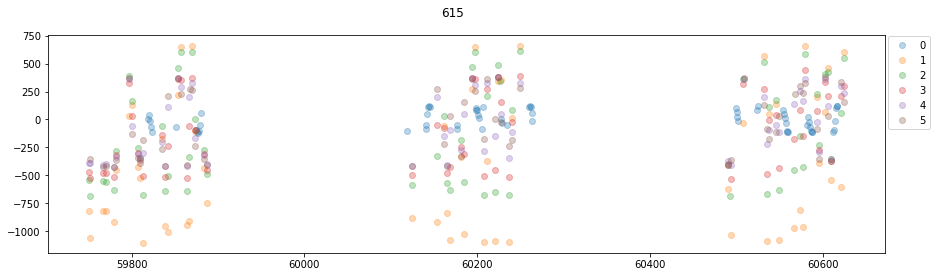

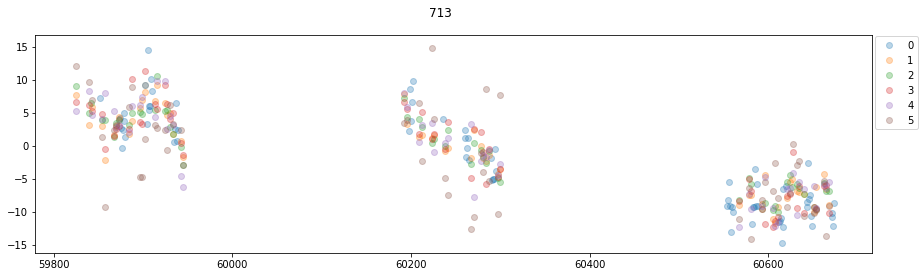

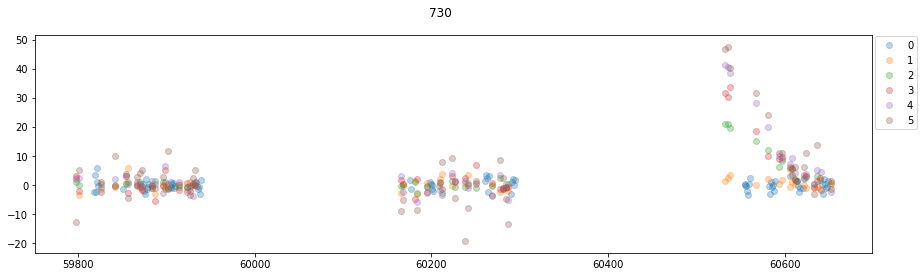

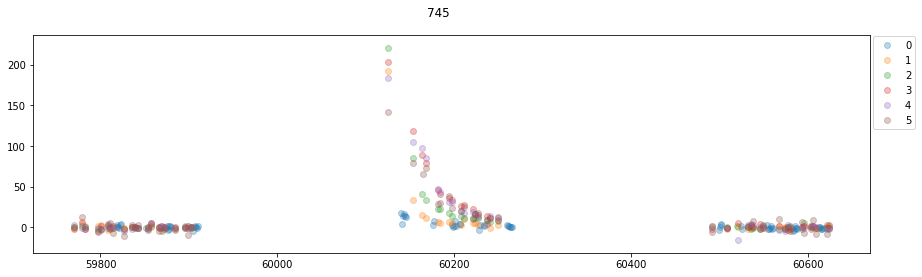

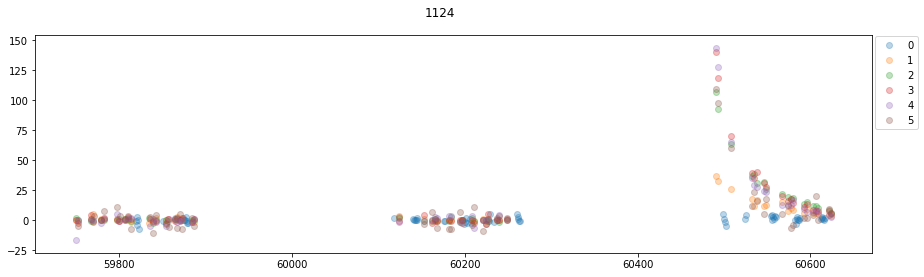

In [48]:
for object_id in object_ids[0:5]:
    plot_time_series_data(TS, object_id=object_id)

# 3. Aggregation and Merging

1. Generate statistial data based on object_id
2. Merge metadata with aggregated data

In [22]:
features = TS.copy()
gc.enable()

# Generate new features
features['flux_ratio_sq'] = np.power(features['flux'] / features['flux_err'], 2.0)
features['flux_by_flux_ratio_sq'] = features['flux'] * features['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

# Rename column names
agg_features = features.groupby('object_id').agg(aggs)
new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
agg_features.columns = new_columns

# Generate new features 
agg_features['mjd_diff'] = agg_features['mjd_max'] - agg_features['mjd_min']
agg_features['flux_diff'] = agg_features['flux_max'] - agg_features['flux_min']
agg_features['flux_dif2'] = (agg_features['flux_max'] - agg_features['flux_min']) / agg_features['flux_mean']
agg_features['flux_w_mean'] = agg_features['flux_by_flux_ratio_sq_sum'] / agg_features['flux_ratio_sq_sum']
agg_features['flux_dif3'] = (agg_features['flux_max'] - agg_features['flux_min']) / agg_features['flux_w_mean']

del agg_features['mjd_max'], agg_features['mjd_min']
del features
gc.collect()
agg_features.head(3)

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697


In [ ]:
# full_features = agg_features.reset_index().merge(
    right=TM,
    how='outer',
    on='object_id'
)

# extract target
if 'target' in full_features:
    target = full_features['target']
    del full_features['target']
classes = sorted(target.unique())

# remove object_id
if 'object_id' in full_features:
    oof_df = full_features[['object_id']]
    del full_features['object_id']
    
print(full_features.shape)
full_features.head(3)

## 4. build model with cross validation

In [24]:
# https://lightgbm.readthedocs.io/en/latest/index.html
# LightGBM parameters
clf_params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'None',
    'learning_rate': 0.5,
    'subsample': .9,
    'colsample_bytree': .75,
    'reg_alpha': 1.0e-2,
    'reg_lambda': 1.0e-2,
    'min_split_gain': 0.01,
#     'min_child_weight': 10,
    'min_child_samples': 20,
#     'n_estimators': 2000,
#     'silent': -1,
#     'verbose': -1,
    'max_depth': 5,
    'importance_type': 'gain',
    'n_jobs': -1
}

In [41]:
# StratifiedKFold can maintain the distribution of different classes while seperating data into training set and validation set
from sklearn.model_selection import StratifiedKFold

In [49]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=17)
train_idx, test_idx = skf.split(full_features, target)
for train_idx, test_idx in skf.split(full_features, target):
    X_trainF, X_testF = full_features.iloc[train_idx], full_features.iloc[test_idx]
    y_trainF, y_testF = target.iloc[train_idx], target.iloc[test_idx]
    break

In [50]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [51]:
boosters = []
importances = pd.DataFrame()
oof_preds = np.zeros((X_trainF.shape[0], y_trainF.unique().shape[0]))

class_dict = {c: i for i, c in enumerate(classes)}
def label_to_code(labels):
    return np.array([class_dict[c] for c in labels])

warnings.simplefilter('ignore', FutureWarning)
for fold_id, (train_idx, validation_idx) in enumerate(folds.split(X_trainF, y_trainF)):
    print('processing fold {0}'.format(fold_id))
    X_train, y_train = X_trainF.iloc[train_idx], y_trainF.iloc[train_idx]
    X_valid, y_valid = X_trainF.iloc[validation_idx], y_trainF.iloc[validation_idx]

    train_dataset = lgb.Dataset(X_train, label_to_code(y_train))
    valid_dataset = lgb.Dataset(X_valid, label_to_code(y_valid))
    
    booster = lgb.train(clf_params_lgb.copy(), train_dataset, num_boost_round=2000, valid_sets=[train_dataset, valid_dataset])
#     booster = lgb.train(clf_params_lgb.copy(), train_dataset, 
#                         num_boost_round=2000,
#                         fobj=wloss_objective, 
#                         feval=wloss_metric,
#                         valid_sets=[train_dataset, valid_dataset],
#                         verbose_eval=100,
#                         early_stopping_rounds=100
#                        )
    oof_preds[validation_idx, :] = booster.predict(X_valid)

    imp_df = pd.DataFrame()
    imp_df['feature'] = full_features.columns
    imp_df['gain'] = booster.feature_importance('gain')
    imp_df['fold'] = fold_id
    importances = pd.concat([importances, imp_df], axis=0)

    boosters.append(booster)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


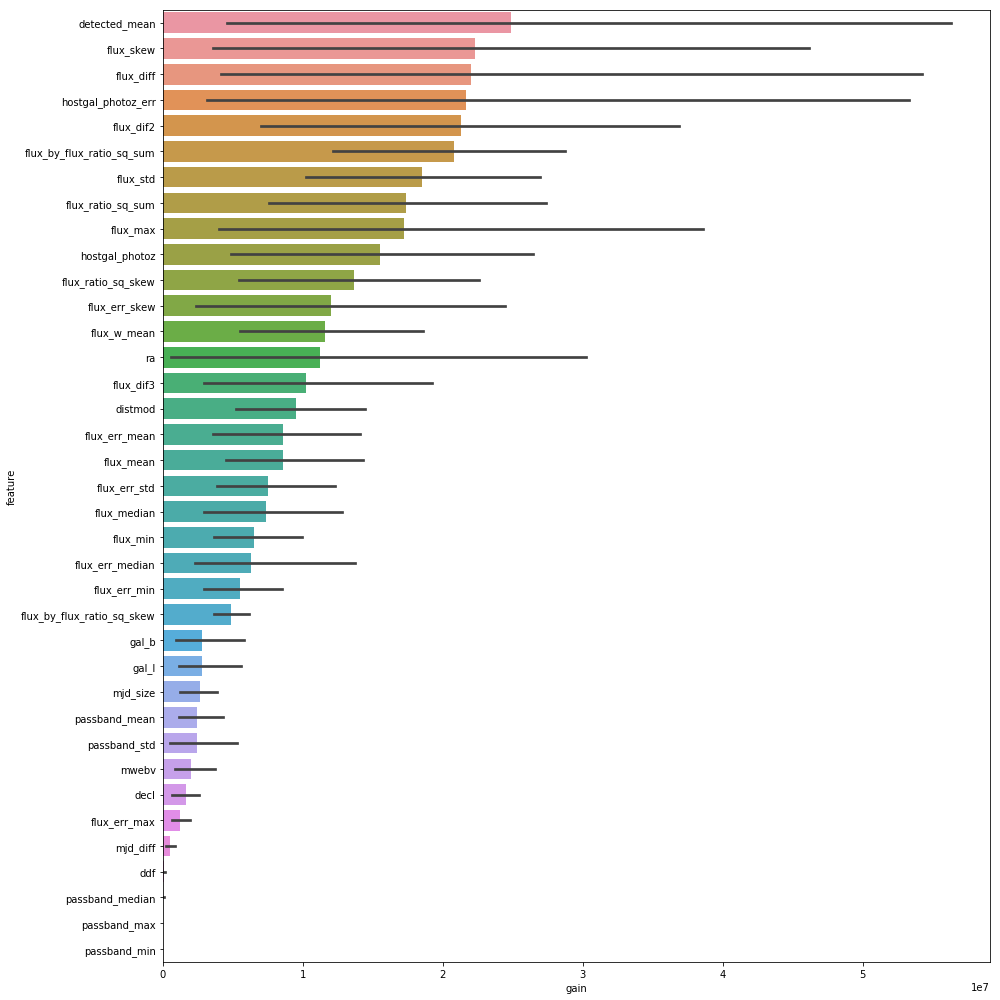

In [52]:
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])
plt.figure(figsize=(14, 14), facecolor='w')
sns.barplot(x='gain', y='feature', 
            data=importances.sort_values('mean_gain', ascending=False).iloc[:5 * 40])
plt.tight_layout()
plt.show()

In [37]:
# boosters = []
# importances = pd.DataFrame()
# oof_preds = np.zeros((full_features.shape[0], target.unique().shape[0]))

# class_dict = {c: i for i, c in enumerate(classes)}
# def label_to_code(labels):
#     return np.array([class_dict[c] for c in labels])

# warnings.simplefilter('ignore', FutureWarning)
# for fold_id, (train_idx, validation_idx) in enumerate(folds.split(full_features, target)):
#     print('processing fold {0}'.format(fold_id))
#     X_train, y_train = full_features.iloc[train_idx], target.iloc[train_idx]
#     X_valid, y_valid = full_features.iloc[validation_idx], target.iloc[validation_idx]

#     train_dataset = lgb.Dataset(X_train, label_to_code(y_train))
#     valid_dataset = lgb.Dataset(X_valid, label_to_code(y_valid))
    
#     booster = lgb.train(clf_params_lgb.copy(), train_dataset, num_boost_round=2000, valid_sets=[train_dataset, valid_dataset])
# #     booster = lgb.train(clf_params_lgb.copy(), train_dataset, 
# #                         num_boost_round=2000,
# #                         fobj=wloss_objective, 
# #                         feval=wloss_metric,
# #                         valid_sets=[train_dataset, valid_dataset],
# #                         verbose_eval=100,
# #                         early_stopping_rounds=100
# #                        )
#     oof_preds[validation_idx, :] = booster.predict(X_valid)

#     imp_df = pd.DataFrame()
#     imp_df['feature'] = full_features.columns
#     imp_df['gain'] = booster.feature_importance('gain')
#     imp_df['fold'] = fold_id
#     importances = pd.concat([importances, imp_df], axis=0)

#     boosters.append(booster)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


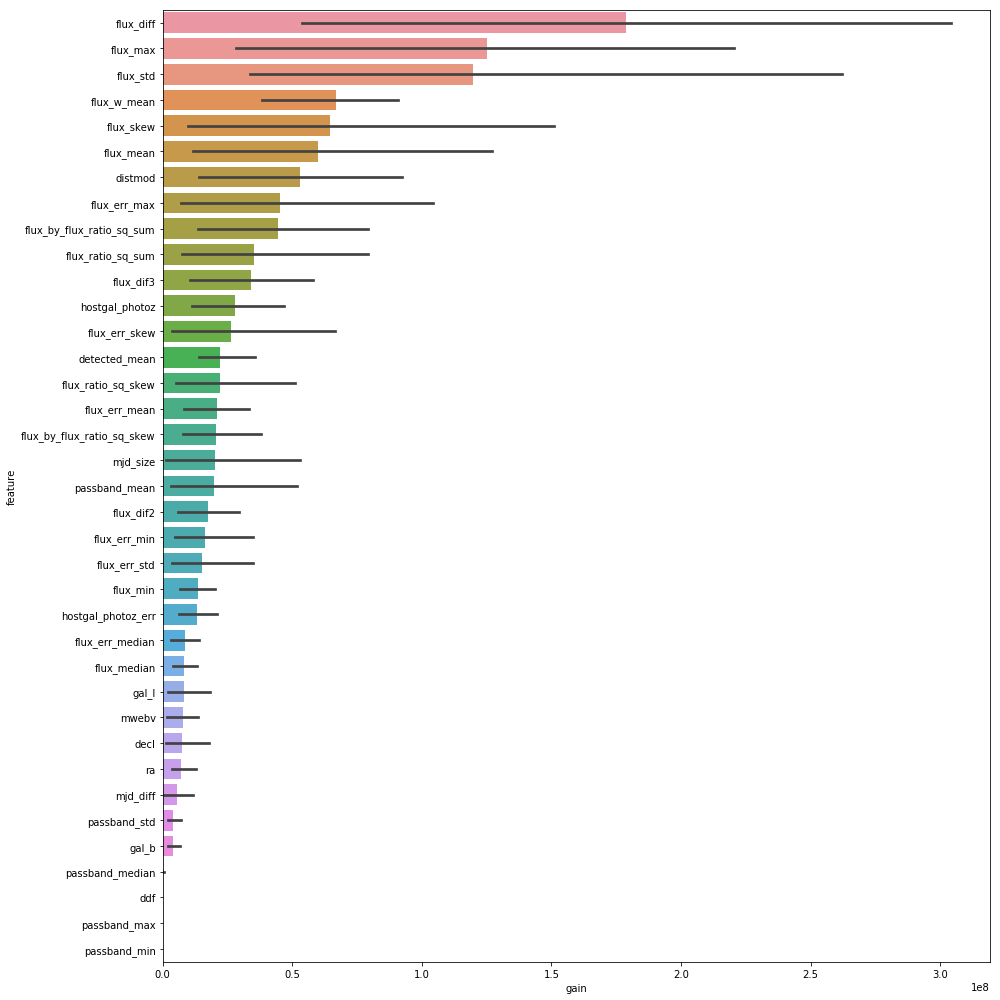

In [38]:
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])
plt.figure(figsize=(14, 14), facecolor='w')
sns.barplot(x='gain', y='feature', 
            data=importances.sort_values('mean_gain', ascending=False).iloc[:5 * 40])
plt.tight_layout()
plt.show()

In [53]:
def softmax(x, axis=1):
    z = np.exp(x)
    return z / np.sum(z, axis=axis, keepdims=True)

In [56]:
# Make predictions
preds = None
for booster in boosters:
    if preds is None:
        preds = softmax(booster.predict(X_testF[full_features.columns])) / folds.n_splits
    else:
        preds += softmax(booster.predict(X_testF[full_features.columns])) / folds.n_splits

In [57]:
preds

array([[ 0.06362019,  0.06362019,  0.08548367, ...,  0.06362019,
         0.12921063,  0.06362019],
       [ 0.06362019,  0.06362019,  0.06362019, ...,  0.08548367,
         0.06362019,  0.06362019],
       [ 0.06362019,  0.06362019,  0.06362019, ...,  0.08548367,
         0.06362019,  0.06362019],
       ..., 
       [ 0.06362019,  0.06362019,  0.12921063, ...,  0.06362019,
         0.06362019,  0.06362019],
       [ 0.06362019,  0.08548367,  0.06362019, ...,  0.08548367,
         0.06362019,  0.06362019],
       [ 0.08548367,  0.06362019,  0.06362019, ...,  0.10734715,
         0.06362019,  0.06362019]])

In [63]:
idxs = preds.argmax(axis=1)
idxs

array([12, 10,  3, ...,  2,  8, 11], dtype=int64)

In [66]:
preds_label = []
class_recover_dict = {i: c for i, c in enumerate(classes)}
preds_label = np.array([class_recover_dict[idx] for idx in idxs])
preds_label

array([92, 88, 42, ..., 16, 65, 90], dtype=int64)

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_testF, preds_label, labels=classes)

array([[ 25,   2,   8,   4,   1,   0,   0,   0,  15,   0,   1,  13,   7,
          0],
       [  1,  30,   4, 114,   0,   0,   4,   5,   1,   0,   0,  89,   0,
          0],
       [ 15,   1, 417,   1,   0,   2,   0,   0,  11,   0,   6,   1,   8,
          0],
       [  1,  52,   7, 297,   0,   0,  10,   6,   3,   2,   2, 215,   0,
          2],
       [  0,   9,   0,  49,   0,   0,   0,   1,   0,   0,   0,  33,   0,
          0],
       [  0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   1,  12,
          0],
       [  1,  24,   0, 113,   1,   0,   5,   6,   1,   2,   1,  88,   0,
          0],
       [  1,   0,   2,   8,   1,   0,   3,  11,   5,   0,   0,  20,   0,
          0],
       [ 13,   0,  19,  13,   0,   1,   4,   1, 416,   0,   2,  20,   2,
          0],
       [  0,   5,   0,  46,   1,   0,   3,   0,   1,   0,   0,  48,   0,
          0],
       [  4,   4,   8,  45,   0,   0,   0,   0,   0,   0, 117,   4,   1,
          2],
       [  2,  33,   7, 429,   0,   0,  18, 

In [69]:
from sklearn.metrics import accuracy_score
accuracy_score(y_testF, preds_label)

0.5224032586558045